# Files

In this Notebook, the data which is stored in different files will be loaded, cleaned, and merged. Feature engineering will be carried out and the prepared Data will be saved for further use.
For this weeks task filtering should only be done on the state Level, that is filter the data by state=Guayas

In [1]:
# Import the required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# User Defined Functions

In [2]:
# Function which prints Information about the dataset
def print_info(df_dict):
    for df, dataset in df_dict.items():
        print(f"Information for {df}:")
        print(dataset.info())
        print(f"Firts Five Rows: \n{dataset.head()}")
        print(f"Missing Values: \n{dataset.isnull().sum()}")
        print('*'*45)
        print('\n')
        print()

In [3]:
# Funtion to calculate z-score for each group (score-item combination)
def calculate_store_item_score(group):
    # compute mean and standard deviation
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()
    
    # calculate z-score (avoiding division by zero for standard deviation)
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    
    return group

In [4]:
# Load CSV Files
df_stores = pd.read_csv('../data/stores.csv')
df_items = pd.read_csv('../data/items.csv')
df_transactions = pd.read_csv('../data/transactions.csv')
df_oil = pd.read_csv('../data/oil.csv')
df_holidays_events = pd.read_csv('../data/holidays_events.csv')

Because the train.csv file is very large, it will be read in chunks and at the same time filtered for stores only the the state Guayas.

In [5]:
# Guayas store_ids
store_ids = df_stores[df_stores['state'] == "Guayas"]['store_nbr'].unique()

# initialize list to hold chunks
filtered_chunks = []

# define chunk size, number of rows per chunk
chunk_size = 10 ** 6

# Read CSV
for chunk in pd.read_csv('../data/train.csv', chunksize=chunk_size, low_memory=False):
    # Filter the chunk for Guayas store_id
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    filtered_chunks.append(chunk_filtered)
    del chunk
    
df_train = pd.concat(filtered_chunks, ignore_index=True)

# free up space
del filtered_chunks

# check dataframe
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,18789,2013-01-02,24,103665,6.0,NaN
1,18790,2013-01-02,24,105574,12.0,NaN
2,18791,2013-01-02,24,105575,2.0,NaN
3,18792,2013-01-02,24,105577,1.0,NaN
4,18793,2013-01-02,24,105693,7.0,NaN


As per instructions, only 2000000 row should be randomly selected from the data and only items bought by the top three families should be considered.

In [6]:
# Sample the train dataset and select only 2000000 rows and ensure repeatability, that is the same dataset will be selected at all times
df_train = df_train.sample(2000000, random_state=42).reset_index(drop=True)
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,36402992,2014-12-01,26,1696038,2.234,False
1,40318340,2015-01-31,27,804974,18.000,False
2,2631489,2013-03-06,51,838216,45.000,NaN
3,24252889,2014-05-23,27,207857,6.000,False
4,46434803,2015-05-10,29,679926,4.000,False


In [7]:
# Fill Missing in df_train with False
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

/var/folders/ck/1rnhhxdd7q9gqh702_wr4zym0000gn/T/ipykernel_66771/1885111277.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


# Filter by Top Three Families

In [8]:
#df_items.head(20)
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)

Show a plot of the Items by Top Three Famiies

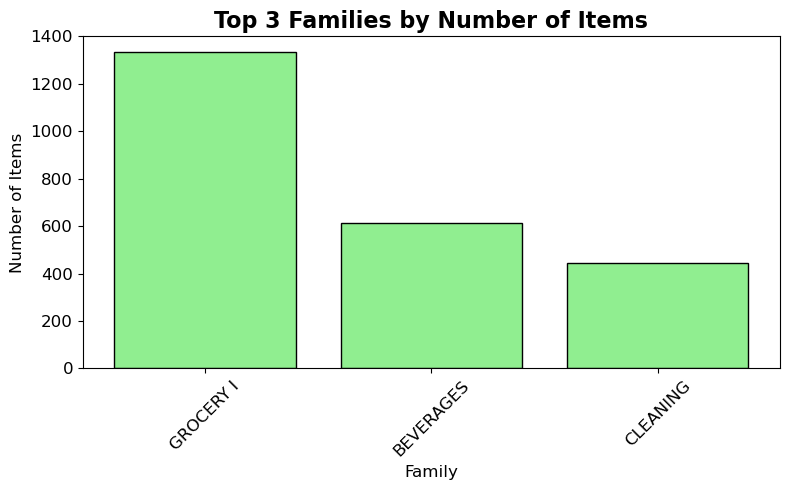

In [9]:

# Plot of Top 3 Family data
plt.figure(figsize=(8,5))
plt.bar(top_3_families['Family'], top_3_families['Item Count'], color='lightgreen', edgecolor='black')
plt.title("Top 3 Families by Number of Items", fontsize=16, fontweight='bold')
plt.xlabel("Family", fontsize=12)
plt.ylabel("Number of Items", fontsize=12)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
# Display the plot
plt.show()

## Filtering Top 3 Families

In [10]:
# Filkter the df_train by item_id of the top 3 families
item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]
print(df_train.head())
print()
print(df_train.shape)

         id        date  store_nbr  item_nbr  unit_sales  onpromotion
1  40318340  2015-01-31         27    804974        18.0        False
3  24252889  2014-05-23         27    207857         6.0        False
5  42964215  2015-03-15         51   1037412         1.0        False
7  90777969  2016-09-12         24   1463569         5.0        False
9  32543916  2014-10-07         32    874593        13.0        False

(1285637, 6)


# Exploratory Data Analysis

In this section, i clean the data by checking and handling missing values.

In [11]:
# create a dictionary of all the datasets to be used in the analysis
dict_dfs = {
    'store': df_stores,
    'items': df_items,
    'transactions': df_transactions,
    'oil': df_oil,
    'holidays': df_holidays_events,
    'train': df_train
}


# Print Dataset Informations
print_info(dict_dfs)


Information for store:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None
Firts Five Rows: 
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
Missing Values: 
store_nbr    0
city         0
state        0
type         0
cluster 

# Handle Missing Values & Outliers

In [12]:
# Check for negative sales
negative_sales = df_train[df_train['unit_sales'] < 0]

# Handle Negative Sales by replacing them with 0 to indicate no sale or returned item
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

# drop id column
df_train.drop(columns='id', inplace=True)

df_train.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
1,2015-01-31,27,804974,18.0,False
3,2014-05-23,27,207857,6.0,False
5,2015-03-15,51,1037412,1.0,False
7,2016-09-12,24,1463569,5.0,False
9,2014-10-07,32,874593,13.0,False


In [13]:
# Check for date range in the dataset
min_date = df_train['date'].min()
max_date = df_train['date'].max()

print(f"Minimum Date: {min_date} , Maximum Date: {max_date})")

Minimum Date: 2013-01-02 , Maximum Date: 2017-08-15)


## Handle Outliers

In [14]:
# Apply the z-score calculate_store_item_score to the df_traing. Since we will be predicting by store-item groups, we need to group the data by store_nbr and item_nbr before applying the z-score
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_score)
df_train_grouped.reset_index(drop=True, inplace=True)

# z-score threshold (z_score > 5)

# print Number of row in dataset
print(f"Number of Rows: {len(df_train_grouped)}")
# Check outliers
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

# print the number of outliers
print(f"Number of Outliers: {len(outliers)}")

print(outliers.head())

Number of Rows: 1285637
Number of Outliers: 3421
            date  store_nbr  item_nbr  unit_sales  onpromotion    z_score
158   2013-08-25         24    105574        59.0        False   6.235813
388   2013-11-13         24    105575       115.0        False  10.142474
794   2014-12-22         24    105857       111.0        False   8.103027
937   2015-05-21         24    108079        17.0        False   5.871246
1468  2013-11-13         24    111223       109.0        False  10.915649


/var/folders/ck/1rnhhxdd7q9gqh702_wr4zym0000gn/T/ipykernel_66771/2989273617.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_score)


Because the outliers seem to be high sales for the particular store and item. I will not drop them.

Next we handle missing sales dates in the datset

In [15]:
df_train.isnull().sum()

date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64

## Handle Missing Dates

In [16]:
# convert date column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Get full date range
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})
full_date_range

,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-06
...,...
1682,2017-08-11
1683,2017-08-12
1684,2017-08-13
1685,2017-08-14


With a full list of dates, we create a dataframe of all store-item-dates combination

In [17]:
# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how='cross')
#all_combinations.dtypes
all_combinations

,store_nbr,item_nbr,date
0,27,804974,2013-01-02
1,27,804974,2013-01-03
2,27,804974,2013-01-04
3,27,804974,2013-01-05
4,27,804974,2013-01-06
...,...,...,...
34554816,30,2048242,2017-08-11
34554817,30,2048242,2017-08-12
34554818,30,2048242,2017-08-13
34554819,30,2048242,2017-08-14


Now merge all_combinations and df_train on store_nbr, item_nbr, dates. The result is a completely filled date column, but with missing unit sales values which we fill with 0's

In [18]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)

# Check the first few rows
df_filled.sort_values(by=['store_nbr', 'item_nbr', 'date'])


df_filled.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion
0,27,804974,2013-01-02,0.0,NaN
1,27,804974,2013-01-03,0.0,NaN
2,27,804974,2013-01-04,0.0,NaN
3,27,804974,2013-01-05,0.0,NaN
4,27,804974,2013-01-06,0.0,NaN


In [29]:
df_filled.isnull().sum()

store_nbr      0
item_nbr       0
date           0
unit_sales     0
onpromotion    0
year           0
month          0
day            0
day_of_week    0
dtype: int64

In [19]:
df_filled['onpromotion'] = df_filled['onpromotion'].fillna(False).astype(bool)

/var/folders/ck/1rnhhxdd7q9gqh702_wr4zym0000gn/T/ipykernel_66771/4097655410.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled['onpromotion'] = df_filled['onpromotion'].fillna(False).astype(bool)


In [20]:
print(df_filled.shape)
print()
print(df_filled.isnull().sum())

df_filled['onpromotion'].fillna(False).astype(bool)

(34554821, 5)

store_nbr      0
item_nbr       0
date           0
unit_sales     0
onpromotion    0
dtype: int64


0           False
1           False
2           False
3           False
4           False
            ...  
34554816    False
34554817    False
34554818    False
34554819    False
34554820    False
Name: onpromotion, Length: 34554821, dtype: bool

In [21]:
df_filled.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion
0,27,804974,2013-01-02,0.0,False
1,27,804974,2013-01-03,0.0,False
2,27,804974,2013-01-04,0.0,False
3,27,804974,2013-01-05,0.0,False
4,27,804974,2013-01-06,0.0,False


In [22]:
# Save the current state of the dataset back to df_train and delete df_filled
df_train = df_filled

del df_filled

df_train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion
0,27,804974,2013-01-02,0.0,False
1,27,804974,2013-01-03,0.0,False
2,27,804974,2013-01-04,0.0,False
3,27,804974,2013-01-05,0.0,False
4,27,804974,2013-01-06,0.0,False


Since prediction will be made on store_nbr-item_nbr in the Guayas region, we need to

In [23]:
df_train.shape

(34554821, 5)

# Features Engineering

In [24]:
# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
print("Data range: from",df_train['date'].dt.date.min(),"till",df_train['date'].dt.date.max())

Data range: from 2013-01-02 till 2017-08-15


In [25]:
# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek
# Calculating rolling average of unit_sales
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())


In [28]:
# Create 'weekend' column: 1 if Saturday (5) or Sunday (6), else 0
df_train['weekend'] = df_train['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

In [29]:
df_train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,weekend
0,27,804974,2013-01-02,0.0,False,2013,1,2,2,NaN,0
1,27,804974,2013-01-03,0.0,False,2013,1,3,3,NaN,0
2,27,804974,2013-01-04,0.0,False,2013,1,4,4,NaN,0
3,27,804974,2013-01-05,0.0,False,2013,1,5,5,NaN,1
4,27,804974,2013-01-06,0.0,False,2013,1,6,6,NaN,1


In [30]:
df_train.shape

(34554821, 11)

In [31]:
df_train.dropna(inplace=True, ignore_index=True)

df_train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,weekend
0,27,804974,2013-01-08,0.0,False,2013,1,8,1,0.000000,0
1,27,804974,2013-01-09,0.0,False,2013,1,9,2,0.000000,0
2,27,804974,2013-01-10,2.0,False,2013,1,10,3,0.285714,0
3,27,804974,2013-01-11,0.0,False,2013,1,11,4,0.285714,0
4,27,804974,2013-01-12,6.0,False,2013,1,12,5,1.142857,1


# Data Visualizations

Data Visualisation are to be made only for the Guayas region so we need to filter the stores dataframe for Guayas

In [32]:
df_stores_guayas = df_stores[df_stores['state'] == 'Guayas']
df_stores_guayas.head()

,store_nbr,city,state,type,cluster
23,24,Guayaquil,Guayas,D,1
25,26,Guayaquil,Guayas,D,10
26,27,Daule,Guayas,D,1
27,28,Guayaquil,Guayas,E,10
28,29,Guayaquil,Guayas,E,10


In [33]:
df_stores_guayas.shape

(11, 5)

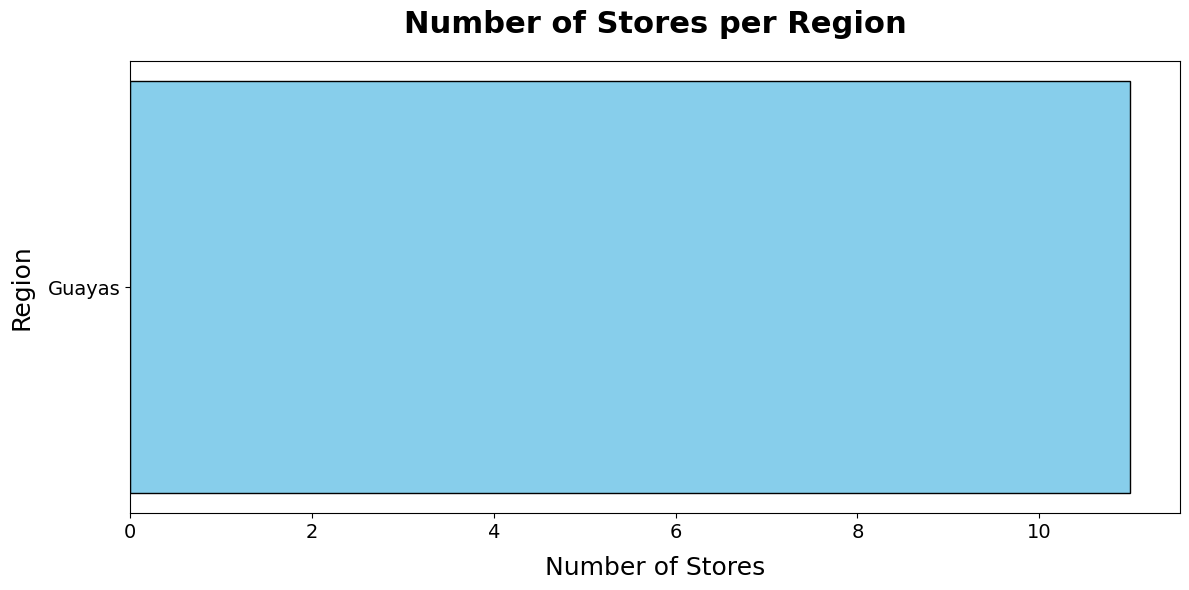

In [34]:
stores_per_region = df_stores_guayas['state'].value_counts().reset_index()
stores_per_region.columns = ['Region', 'Store Count']
stores_per_region = stores_per_region.sort_values(by='Store Count', ascending=True)

# Plot the sorted data
plt.figure(figsize=(12, 6))  # Increase figure size for better readability
plt.barh(stores_per_region['Region'], stores_per_region['Store Count'], color='skyblue', edgecolor='black')  # Use horizontal bar plot
# Titles and labels with enhanced formatting
plt.title("Number of Stores per Region", fontsize=22, fontweight='bold', pad=20)
plt.xlabel("Number of Stores", fontsize=18, labelpad=10)
plt.ylabel("Region", fontsize=18, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

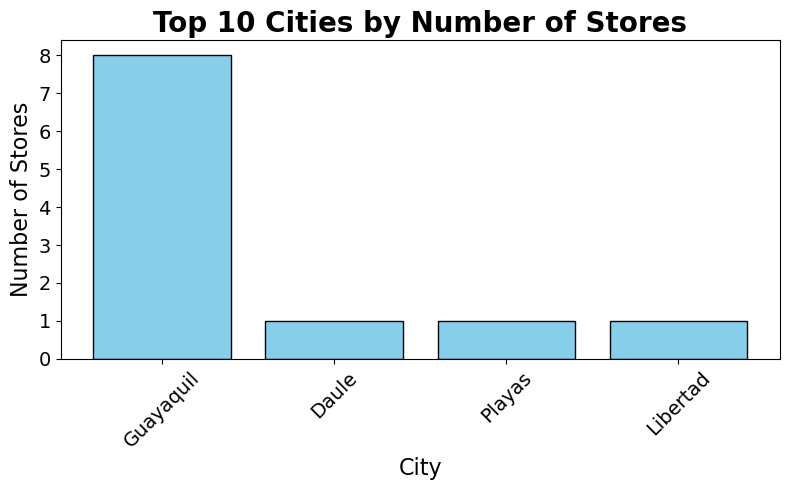

In [36]:
# Plotting the number of stores per city

# Compute the number of stores per city and select the top 10 cities
stores_per_city = df_stores_guayas['city'].value_counts().reset_index()
stores_per_city.columns = ['City', 'Store Count']
top_10_cities = stores_per_city.head(10)  # Keep only the top 10 cities

# Plot the top 10 cities
plt.figure(figsize=(8, 5))
plt.bar(top_10_cities['City'], top_10_cities['Store Count'], color='skyblue', edgecolor='black')
# Add titles and labels with appropriate formatting
plt.title("Top 10 Cities by Number of Stores", fontsize=20, fontweight='bold')
plt.xlabel("City", fontsize=16)
plt.ylabel("Number of Stores", fontsize=16)
# Adjust tick labels for better readability
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
# Ensure layout fits nicely
plt.tight_layout()
# Display the plot
plt.show()

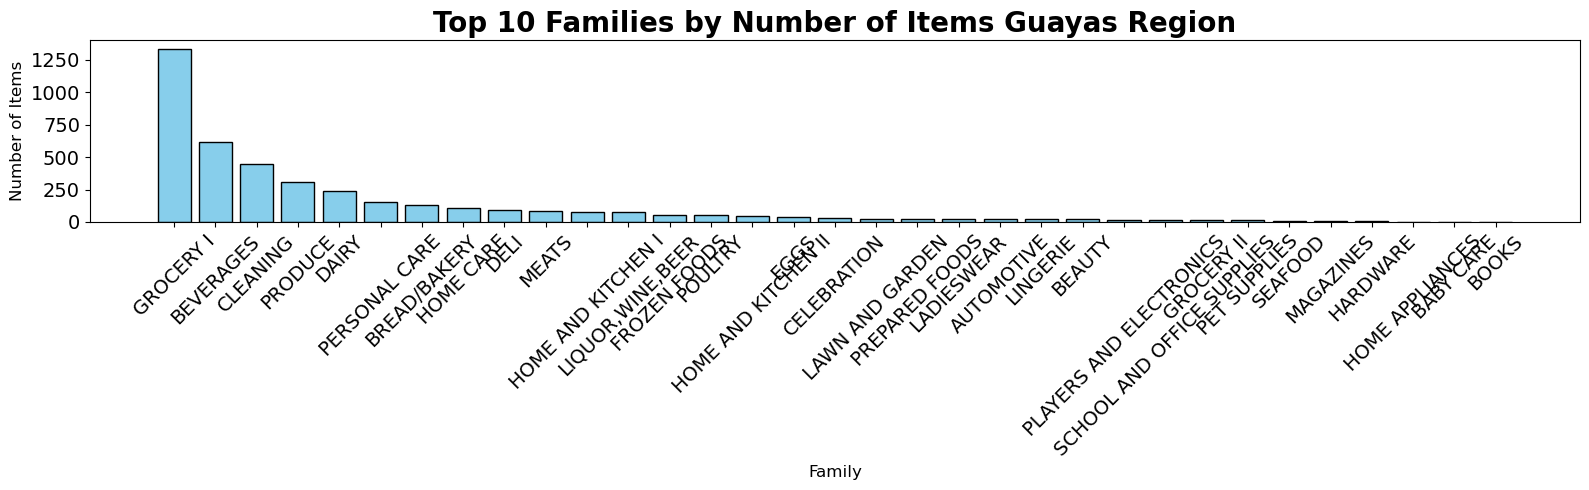

In [37]:
# Plotting the number of items per family (for top 10 families only)
# Plot the top 10 families
plt.figure(figsize=(16, 5))
plt.bar(items_per_family['Family'], items_per_family['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 10 Families by Number of Items Guayas Region", fontsize=20, fontweight='bold')
plt.xlabel("Family", fontsize=12)
plt.ylabel("Number of Items", fontsize=12)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

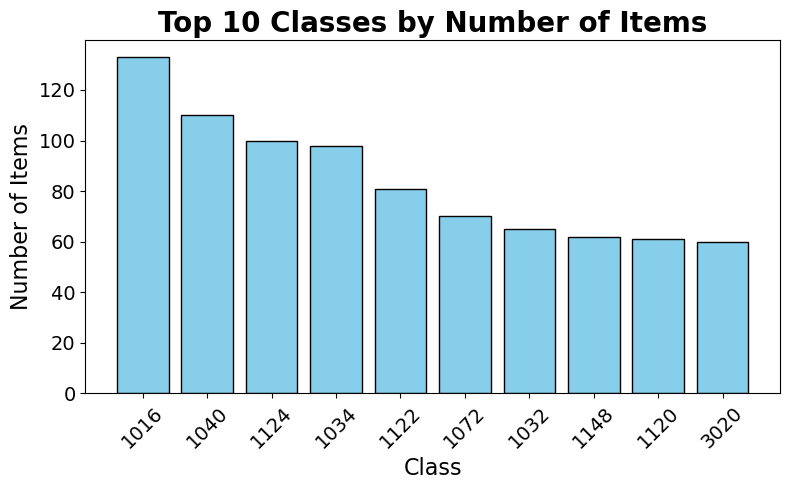

In [38]:
# Plotting the number of items per class
# Compute the number of items per class and select the top 10 classes
items_per_class = df_items['class'].value_counts().reset_index()
items_per_class.columns = ['Class', 'Item Count']
top_10_classes = items_per_class.head(10)  # Keep only the top 10 classes

# Plot the top 10 classes
plt.figure(figsize=(8, 5))
plt.bar(top_10_classes['Class'].astype(str), top_10_classes['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 10 Classes by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Class", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

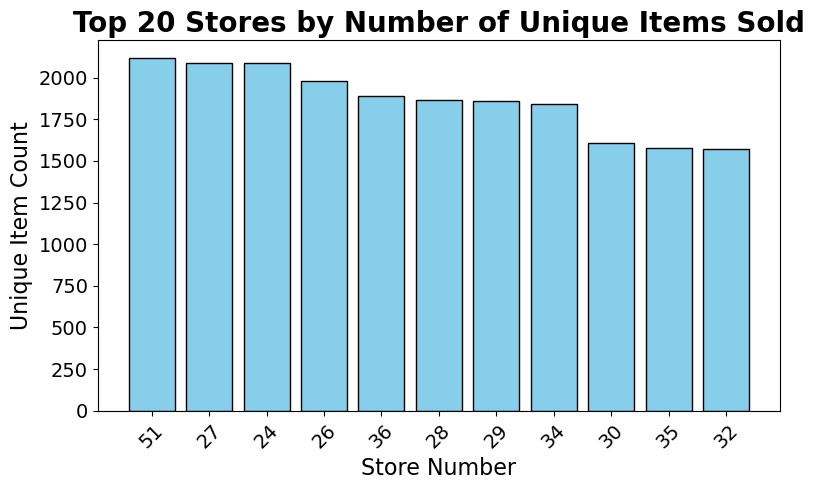

In [39]:
# Calculate the number of unique items per store in df_train
items_per_store = df_train.groupby('store_nbr')['item_nbr'].nunique().reset_index()
items_per_store.columns = ['Store Number', 'Unique Item Count']

# Select the top 10 stores by unique item count
top_20_stores = items_per_store.sort_values(by='Unique Item Count', ascending=False).head(20)
# Plot the top 10 stores
plt.figure(figsize=(8, 5))
plt.bar(top_20_stores['Store Number'].astype(str), top_20_stores['Unique Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 20 Stores by Number of Unique Items Sold", fontsize=20, fontweight='bold')
plt.xlabel("Store Number", fontsize=16)
plt.ylabel("Unique Item Count", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

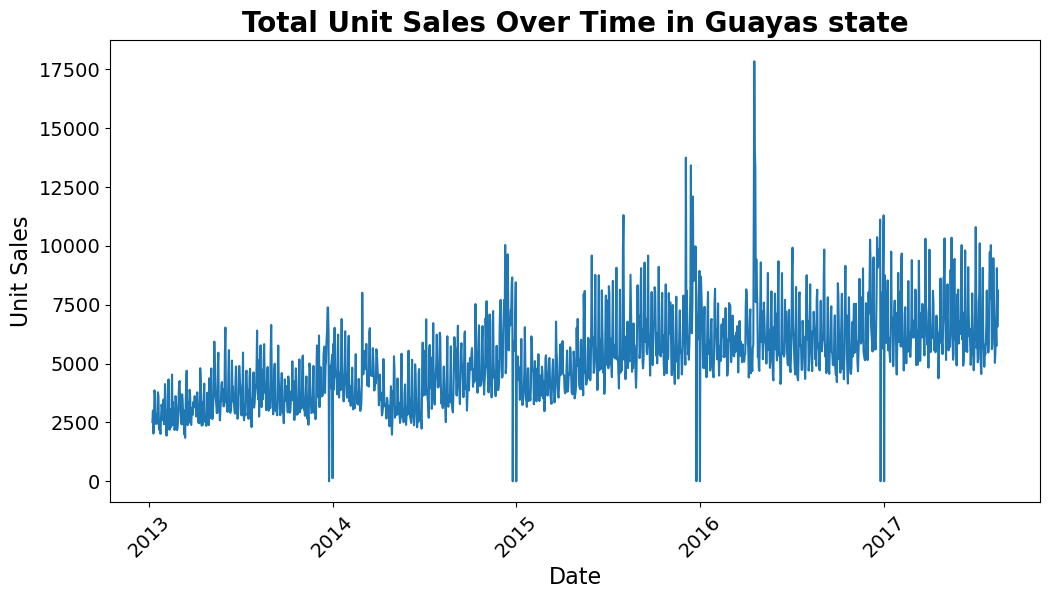

In [40]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

## Sales Trend by Year and Month

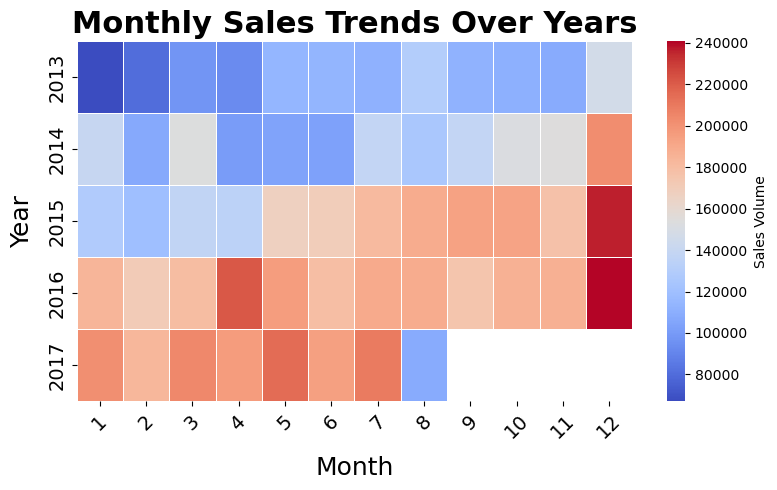

In [41]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

# Plotting heatmap of sales by year and month

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

## Number of Items launched per Month

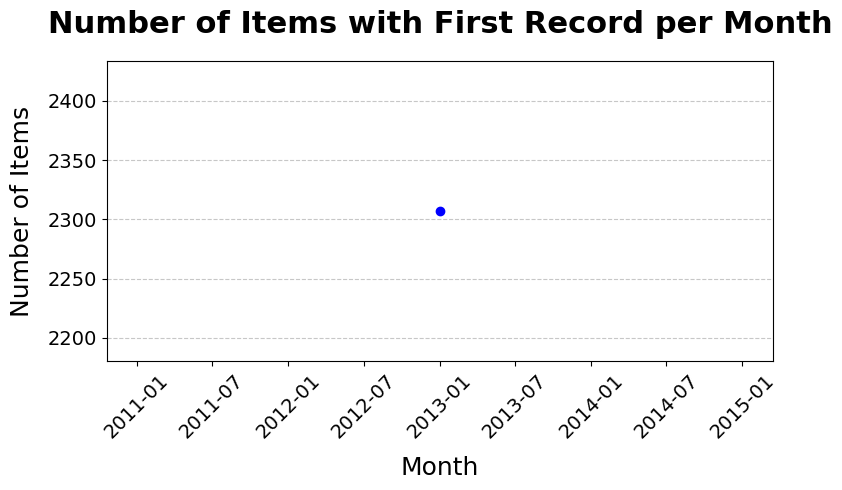

In [42]:
# Identify the first record for each item by date
df_train['date'] = pd.to_datetime(df_train['date'])  # Ensure the date column is in datetime format
first_record_per_item = df_train.groupby('item_nbr')['date'].min().reset_index()

# Extract year and month and count items for each month
first_record_per_item['YearMonth'] = first_record_per_item['date'].dt.to_period('M')
items_per_month = first_record_per_item['YearMonth'].value_counts().sort_index().reset_index()
items_per_month.columns = ['YearMonth', 'Item Count']

# Convert YearMonth back to datetime for plotting
items_per_month['YearMonth'] = items_per_month['YearMonth'].dt.to_timestamp()

# Plot the data
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(items_per_month['YearMonth'], items_per_month['Item Count'], marker='o', linestyle='-', color='b')  # Line plot with markers

# Add titles and labels
plt.title('Number of Items with First Record per Month', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=18, labelpad=10)
plt.ylabel('Number of Items', fontsize=18, labelpad=10)

# Format the x-axis labels
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()

The plot shows, in 2013-01 about 2300 items were launched in Guayas, after that there were no new launches

## Number of items discontinued every month

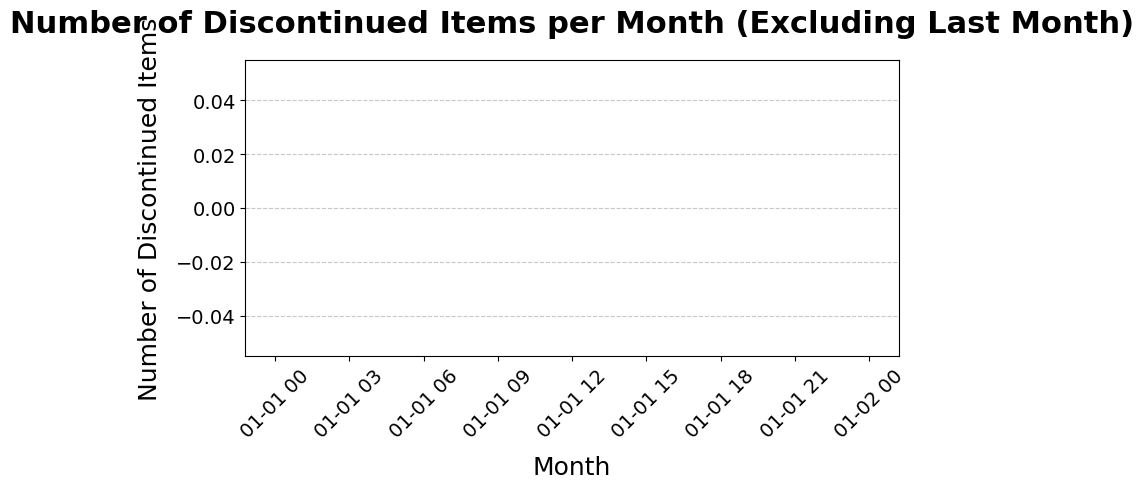

In [43]:
# Identify the last record for each item by date
df_train['date'] = pd.to_datetime(df_train['date'])  # Ensure the date column is in datetime format
last_record_per_item = df_train.groupby('item_nbr')['date'].max().reset_index()

# Extract year and month for each item's last record
last_record_per_item['YearMonth'] = last_record_per_item['date'].dt.to_period('M')

# Exclude the last month in the dataset
last_month = last_record_per_item['YearMonth'].max()
filtered_last_record_per_item = last_record_per_item[last_record_per_item['YearMonth'] != last_month]

# Count items discontinued per month (excluding the last month)
discontinued_items_per_month = filtered_last_record_per_item['YearMonth'].value_counts().sort_index().reset_index()
discontinued_items_per_month.columns = ['YearMonth', 'Item Count']

# Convert YearMonth back to datetime for plotting
discontinued_items_per_month['YearMonth'] = discontinued_items_per_month['YearMonth'].dt.to_timestamp()

# Plot the data
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(discontinued_items_per_month['YearMonth'], discontinued_items_per_month['Item Count'], marker='o', linestyle='-', color='r')  # Line plot with markers

# Add titles and labels
plt.title('Number of Discontinued Items per Month (Excluding Last Month)', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=18, labelpad=10)
plt.ylabel('Number of Discontinued Items', fontsize=18, labelpad=10)

# Format the x-axis labels
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()

There no discontinued items monthly in Guayas region.

## Effect of Promotions on Sales

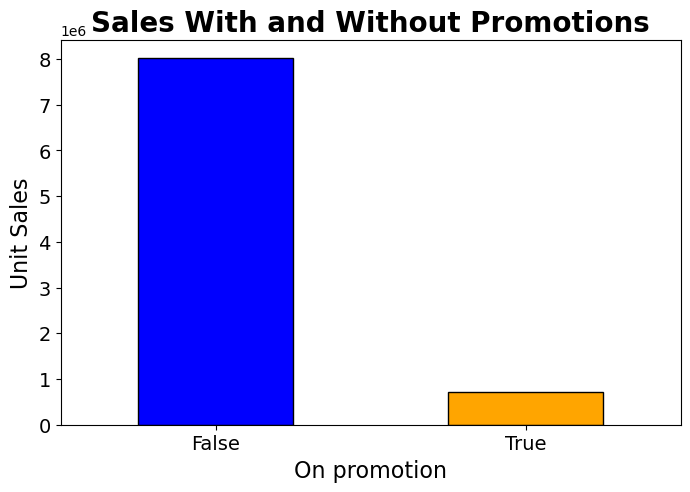

In [44]:
# Aggregating promotion and non-promotion sales
promo_sales = df_train.groupby('onpromotion')['unit_sales'].sum()

# Plotting
plt.figure(figsize=(8,5))
promo_sales.plot(kind='bar', color=['blue', 'orange'], edgecolor='black')
plt.title('Sales With and Without Promotions', fontsize=20, fontweight='bold')
plt.ylabel('Unit Sales', fontsize=16)
plt.xlabel('On promotion', fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14)
plt.show()

Items which were not promoted sold much better than promoted itens. This means promotion did not affect sales.

Effect of Oil prices on Sales

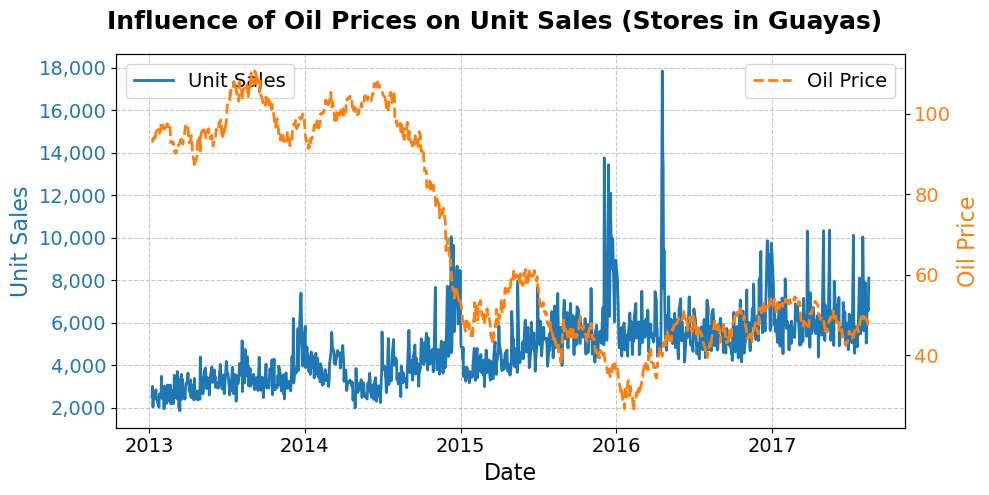

In [45]:
# Ensure datetime formats for merging and plotting
df_train['date'] = pd.to_datetime(df_train['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Aggregate sales data by date (using 'unit_sales')
sales_by_date = df_train.groupby('date')['unit_sales'].sum().reset_index()

# Merge aggregated sales with oil prices
merged_data = pd.merge(sales_by_date, df_oil, on='date', how='left')
del df_oil, sales_by_date  #clean up

# Rename columns for clarity
merged_data.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)

# Drop rows where oil price is NaN
merged_data = merged_data.dropna(subset=['oil_price'])

# Plot unit sales and oil prices
fig, ax1 = plt.subplots(figsize=(10, 5))  # Bigger figure size for better readability

# Plot unit sales on the left y-axis
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Unit Sales', fontsize=16, color='tab:blue')
ax1.plot(merged_data['date'], merged_data['unit_sales'], label='Unit Sales', color='tab:blue', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

# Format y-axis for unit sales
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Plot oil prices on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Price', fontsize=16, color='tab:orange')
ax2.plot(merged_data['date'], merged_data['oil_price'], label='Oil Price', color='tab:orange', linewidth=2, linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=14)

# Add grid, titles, and legends
fig.suptitle('Influence of Oil Prices on Unit Sales (Stores in Guayas)', fontsize=18, fontweight='bold')
ax1.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper right', fontsize=14)
ax1.grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

High oil prices resulted in less sales and vice versa. So oil prices affected sales as can be seen from the graph.

# Effect of holidays on Sales

Holidays range: from 2012-03-02 till 2017-12-26


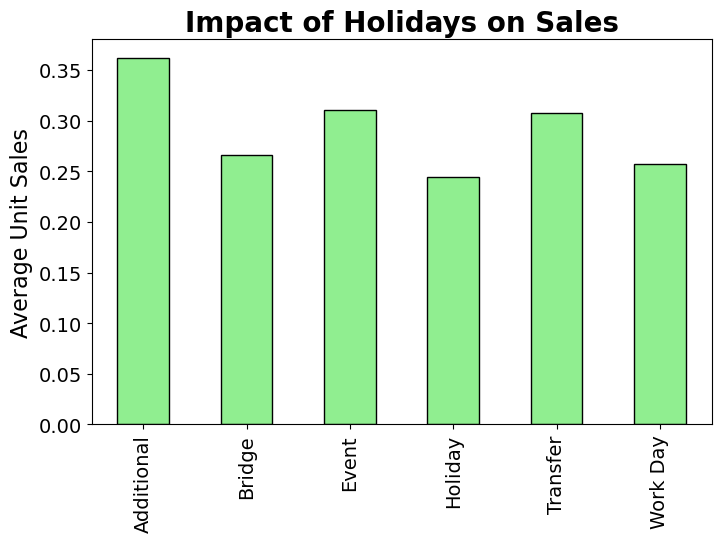

In [46]:
# Convert date column to datetime
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
print("Holidays range: from",df_holidays_events['date'].dt.date.min(),"till",df_holidays_events['date'].dt.date.max())

# Merging df_train data with holidays
df_train_holiday = pd.merge(df_train, df_holidays_events, on='date', how='left')

# Aggregating sales by holiday and non-holiday
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# Plotting holiday impact
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Impact of Holidays on Sales', fontsize=20, fontweight='bold')
plt.ylabel('Average Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Chart shows Sales on the different Holiday types. Additional showing higher sales than all other types.

Effect of Perishable item on Sales

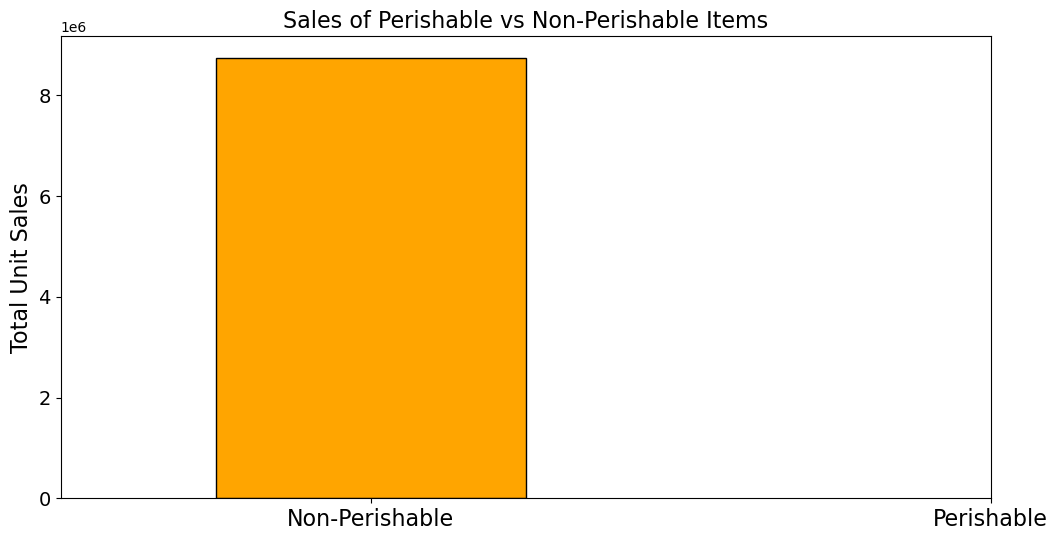

In [47]:
# Merging df_train with items to get perishable data
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train_items['perishable'] = df_train_items['perishable'].astype(bool)
# Aggregating sales by perishable and non-perishable items
perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()

# Plotting sales for perishable and non-perishable items
plt.figure(figsize=(12,6))
perishable_sales.plot(kind='bar', color=['orange', 'green'], edgecolor='black')
plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=16)
plt.ylabel('Total Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1],
    labels=['Non-Perishable', 'Perishable'],
    fontsize=16,
    rotation=0  # Keep x-axis labels horizontal
)
plt.yticks(fontsize=14)
plt.show()

No data for perishable items in Gauyas region. Non Perishable sold pretty well.

In preparation for merging dataset merge, convert all date fiels in the different datasets date time.

# Save Current Data for further Analysis

In [48]:
df_train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,weekend
0,27,804974,2013-01-08,0.0,False,2013,1,8,1,0.000000,0
1,27,804974,2013-01-09,0.0,False,2013,1,9,2,0.000000,0
2,27,804974,2013-01-10,2.0,False,2013,1,10,3,0.285714,0
3,27,804974,2013-01-11,0.0,False,2013,1,11,4,0.285714,0
4,27,804974,2013-01-12,6.0,False,2013,1,12,5,1.142857,1


In [49]:
df_train.to_csv('../data/new_train_cleaned.csv', index=False)